In [1]:
import pygsp as p

import numpy as np
from numpy.linalg import matrix_rank, inv, pinv
import matplotlib.pyplot as plt

import cv2

from scipy import fft

from scipy.sparse.linalg import eigs
from scipy.linalg import eig
from scipy.optimize import linprog, minimize, Bounds

In [2]:
from ripser import ripser
from persim import plot_diagrams

# First example: minimizing (only) the laplacian quadratic form 

$$
    \min_L \ \ x^T L x = \frac{1}{2}\sum_{i, j} w_{ij}(x_i - x_j)^2
$$

In [3]:
data_rs = np.random.RandomState(12345)

In [4]:
# função que define os dados
def start_points(n = 100, r = 1, eps = 0.2, rs = data_rs):
    ps = []
    thetas = []
    for i in range(n):
        theta = rs.uniform(0, 2 * np.pi)
        eps = rs.uniform(-0.2, 0.2)
        x, y  = (r + eps) * np.cos(theta), (r + eps) * np.sin(theta)
        thetas += [theta]
        ps += [[x,y]]
    return thetas, np.array([np.array(q) for q in ps])

In [5]:
def setup_signal(x):
    
    n = len(x)
    coefs = []
    
    for i in range(n):
        for j in range(i, n):
            
            if i == j:
                continue
            
            coefs += [(x[i] - x[j]) ** 2]
    
    return np.array(coefs)

def setup_A_eq(x):
    
    n = len(x)
    indexes = [i for i in range(n ** 2)]

    for k in range(n ** 2):
        #por algum motivo estava pulando os ifs, ai separei
        if (k % n) == (k // n):
            
            indexes.remove(k)
            continue
    
        if (k % n) < (k // n):
            
            indexes.remove(k)
            continue
    
    A_eq = 2 * np.ones((1, len(indexes)))
    
    return A_eq

def get_bounds(L):
    
    return len(L) * [(0, None)]

def laplacian_quadratic_form(L, x):
    
    n = len(x)
    indexes = [i for i in range(n ** 2)]
    
    for k in range(n ** 2):
        
        if (k % n) == (k // n):
            
            indexes.remove(k)
        
        if (k % n) < (k // n):
            
            indexes.remove(k)

    return 1/2 * sum([abs(L[k]) * (x[k % n] - x[k // n]) ** 2 for k in indexes])

In [6]:
def make_graph(n, ws, tol = 10):
    
    new_ws = np.round(ws, tol)
    W = np.zeros((n, n))
    W[np.triu_indices(n, 1)] = new_ws
    for i in range(1, n):
        for j in range(i):
            W[i, j] = W[j, i]
    return p.graphs.Graph(W)

In [7]:
thetas, data = start_points(50)
signal1 = np.array(thetas)
signal2 = np.cos(thetas)
signal3 = np.sin(thetas)

In [8]:
A_eq = setup_A_eq(signal1)

l1 = lambda L: laplacian_quadratic_form(L, signal1)
l2 = lambda L: laplacian_quadratic_form(L, signal2)
l3 = lambda L: laplacian_quadratic_form(L, signal3)

N = 505

In [9]:
%%time 
#demora bastante
#valor aleatorio pode causar um warning, mas o resultado ainda funciona
res1 = linprog(setup_signal(signal1),
              A_eq = A_eq,
              b_eq = [N], #esse valor junto com as restrições (0, 1)
              bounds = (0, 1), #para os pesos força o grafo a ter mais arestas
              options = {'sym_pos': False},) #evita dois warnings

res2 = linprog(setup_signal(signal2),
              A_eq = A_eq,
              b_eq = [N], 
              bounds = (0, 1), 
              options = {'sym_pos': False},)

res3 = linprog(setup_signal(signal3),
              A_eq = A_eq,
              b_eq = [N], 
              bounds = (0, 1), 
              options = {'sym_pos': False},)

CPU times: user 32 s, sys: 1 s, total: 33 s
Wall time: 4.54 s


In [10]:
G1 = make_graph(len(signal1), res1.x)
G1.set_coordinates(data)

G2 = make_graph(len(signal2), res2.x)
G2.set_coordinates(data)

G3 = make_graph(len(signal3), res3.x)
G3.set_coordinates(data)

In [11]:
G1.compute_fourier_basis()
G2.compute_fourier_basis()
G3.compute_fourier_basis()

In [12]:
graphs = [G1, G2, G3]
titles0 = ['Angle, number of edges: ' + str(G1.Ne),
          'Cosine, number of edges: ' + str(G2.Ne),
          'Sine, number of edges: ' + str(G3.Ne)]
titles1 = 3 * ['Frequencies of signal learned on graph above']
signals = [signal1, signal2, signal3]
gfts = [G1.gft(signal1), G2.gft(signal2), G3.gft(signal3)]

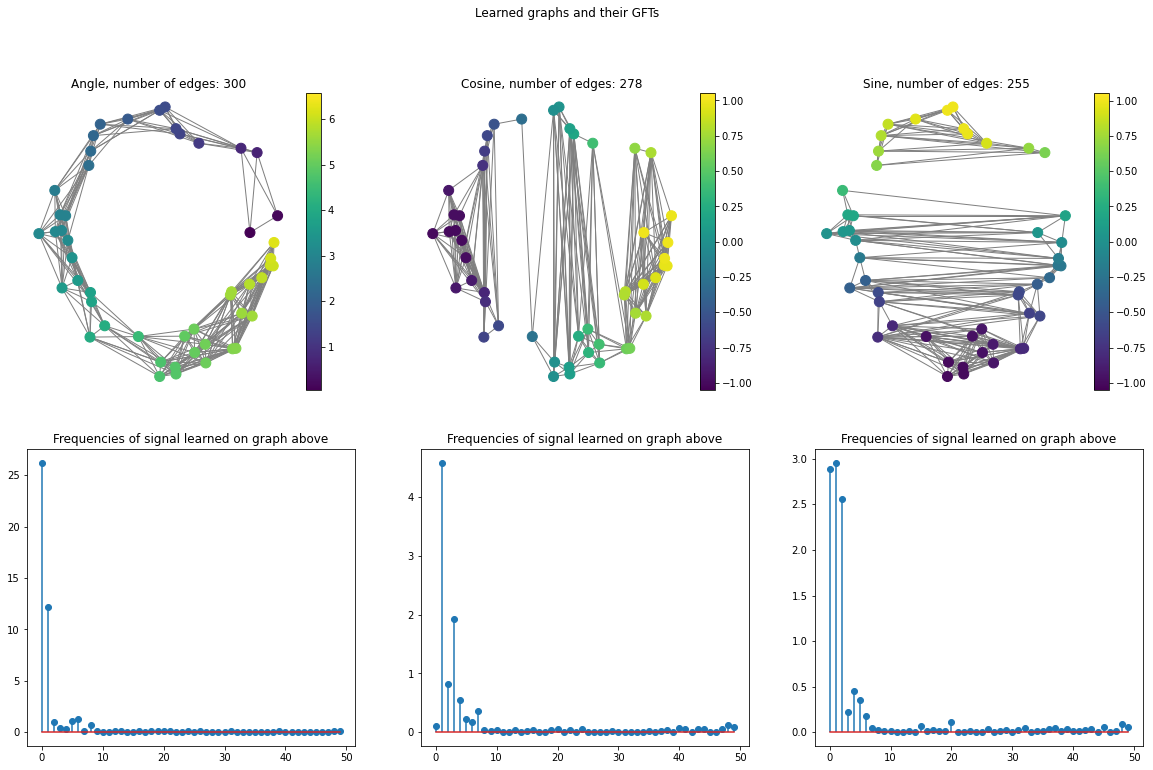

In [13]:
fig, ax = plt.subplots(2, 3, figsize = (20, 12))

for i in [0, 1, 2]:

    graphs[i].plot_signal(signals[i], ax = ax[0][i])
    ax[0][i].set_title(titles0[i])
    ax[0][i].axis('off')
    ax[1][i].stem(np.abs(gfts[i]))
    ax[1][i].set_title(titles1[i])

fig.suptitle('Learned graphs and their GFTs')

# plt.savefig('imgs/test4/borsuk-ulam')
plt.show()

In [14]:
G1.is_connected(), G2.is_connected(), G3.is_connected()

(True, True, False)

# Second example (wrong?):

$$
    \min_{y, L} \ \ \|x - y \|^2_2 + \alpha y^T L y, \text{where } L = V^{-1} \Lambda V \text{ and } y = Vc
$$

In [15]:
def vector_to_matrix(n, ws):
    
    W = np.zeros((n, n))
    indexes = np.triu_indices(n, k = 1)
    W[indexes] = ws
    W[indexes[::-1]] = ws
    degrees = [sum(W[i]) for i in range(n)]
    
    return W, degrees

def objective_function(x, y_and_ws, α, β):
    
    n, m = np.shape(x)
    y, ws = y_and_ws[:n * m], y_and_ws[n * m:]
    y = y.reshape((n, m))
    W, ds = vector_to_matrix(np.shape(x)[0], ws)
    L = np.diag(ds) - W
    norm = np.linalg.norm(x - y)
    trace = np.trace(y.T @ L @ y)
    lap_norm = np.linalg.norm(L)
    
#     return trace
    return norm + α * trace + β * lap_norm

def constraints(N, n, m):
    
     return ({'type': 'eq', 'fun': lambda c: 2 * sum(c[n * m:]) - N})

def bounds(k, n, m):
    
    return (k - n * m) * [(-2, 2)] + (n * m) * [(0, 1)]

In [16]:
rs_noise = np.random.RandomState(1111)
x = np.array([[-1, -1, -1, -0.5, 0, 0.5, 1, 1, 1], [-1, -1, -1, -0.5, 0.2, 0.5, 1, 1, 1], [-1, -1, -1, -0.5, -0.3, 0.5, 1, 1, 1]]).T
noise = rs_noise.normal(size = np.shape(x.T))/10000
x += noise.T

In [17]:
y = np.zeros(np.shape(x))
n, m = np.shape(y)
L0 = np.arange(0, n ** 2, 1).reshape((n, n))
# L0 = np.ones((n, n))
ws = L0[np.triu_indices(np.shape(y)[0], k = 1)]
y_and_ws = np.append(x.reshape(n * m), ws)

f = lambda y_and_ws: objective_function(x, y_and_ws, .001, .1) 

In [18]:
%%time
N = 0.39
res = minimize(f, np.array(y_and_ws), bounds = bounds(len(y_and_ws), *np.shape(x)), constraints = constraints(N, *np.shape(x)))

CPU times: user 141 ms, sys: 0 ns, total: 141 ms
Wall time: 155 ms


In [19]:
n, m = np.shape(x)
y_opt, ws_opt = res.x[:n * m].reshape(m, n), res.x[n * m:]

In [20]:
H = make_graph(np.shape(x)[0], ws_opt, tol = 2)
H.set_coordinates(np.array([
       [ 0.69917073,  0.32620421],
       [ 0.50023714,  1.        ],
       [ 0.15639036,  0.77325707],
       [ 0.86724127,  0.70392536],
       [ 0.00167925,  0.0028878 ],
       [-0.15909354, -0.75490958],
       [-0.85603297, -0.71946971],
       [-0.72278692, -0.32438449],
       [-0.48680532, -1.00751066]
       ]))

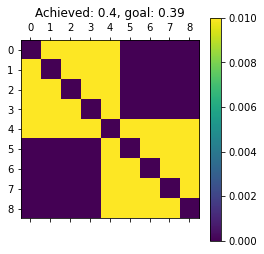

In [21]:
plt.matshow(H.W.todense())
plt.colorbar()
plt.title('Achieved: ' + str(np.round(np.trace(H.L.todense()), 3)) + ', goal: ' + str(N))
plt.show()

In [22]:
H.compute_fourier_basis()

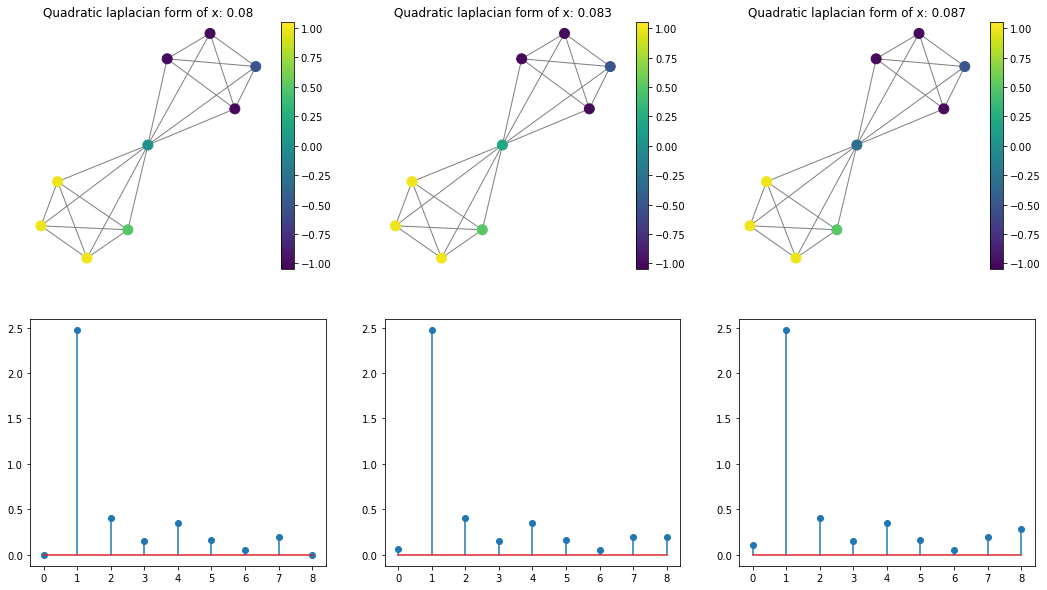

In [23]:
fig, ax = plt.subplots(2, 3, figsize = (18, 10))


for i in [0,1,2]:
    H.plot_signal(x.T[i], ax=ax[0][i])
    ax[1][i].stem(np.abs(H.gft(x.T[i])))
    ax[0][i].axis('off')
#     ax[1][i].axis('off')
    ax[0][i].set_title('Quadratic laplacian form of x: ' + str(np.round(x[:, i] @ H.L @ x[:, i], 3)))
#     ax[1][i].set_title(y[:, i] @ H.L @ y[:, i])

plt.show()

# Third example (Spielman):

$$
   \min_w \ \ f(w) = \| L X\|^2_F, \ \ \ \text{ where } w \text{ are the weights of the laplacian } L \text{ and } X \text{ is a } n \times d \text{ matrix of signals} 
$$

In [24]:
def objective_function_spielman(x, ws):
    
    n, d = np.shape(x)
    W, ds = vector_to_matrix(np.shape(x)[0], ws)
    L = np.diag(ds) - W
#     print(np.trace(L) - α * n)
#     print(α * n - np.trace(L))
    
    return np.linalg.norm(L @ x)

def constraints_spielman(n, c, α):
    
    _, ds = vector_to_matrix(n, c)
    g = lambda c: α * n - sum([max(0, 1 - di) for di in ds]) 
#     g = lambda c: sum([max(0, 1 - di) for di in ds]) - α * n 
    return ({'type': 'ineq', 'fun': g})

def bounds_spielman(n):
    
    return n * [(0, None)]

In [25]:
x = np.array([
            [-1.75, -1.5, -1.25, -0.5, 0, 0.5, 1.25, 1.5, 1.75],
            [1, 2, 3, 4, 5, 4, 3, 2, 1],
            [0, 1, 2, 3, 4, 5, 6, 7, 8]]).T

n, d = np.shape(x)

L0 = np.arange(0, n ** 2, 1).reshape((n, n))/100
# L0 = 0.000005 * np.ones((n, n))
ws = L0[np.triu_indices(np.shape(x)[0], k = 1)]

g = lambda ws: objective_function_spielman(x, ws)

In [26]:
%%time
α = 0.1
res = minimize(g, ws, bounds = bounds_spielman(len(ws)), constraints = constraints_spielman(n, ws, α), 
               tol = 1e-6)

CPU times: user 109 ms, sys: 15.6 ms, total: 125 ms
Wall time: 108 ms


In [27]:
L = make_graph(np.shape(x)[0], res.x, tol = 10)
L.set_coordinates()

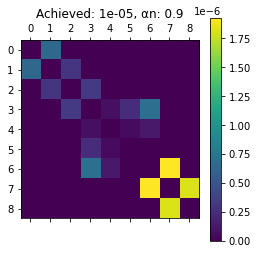

In [28]:
plt.matshow(L.W.todense())
plt.colorbar()
plt.title('Achieved: ' + str(np.round(np.trace(L.L.todense()), 5)) + ', αn: ' + str(α * n))
plt.show()

In [29]:
L.compute_fourier_basis()

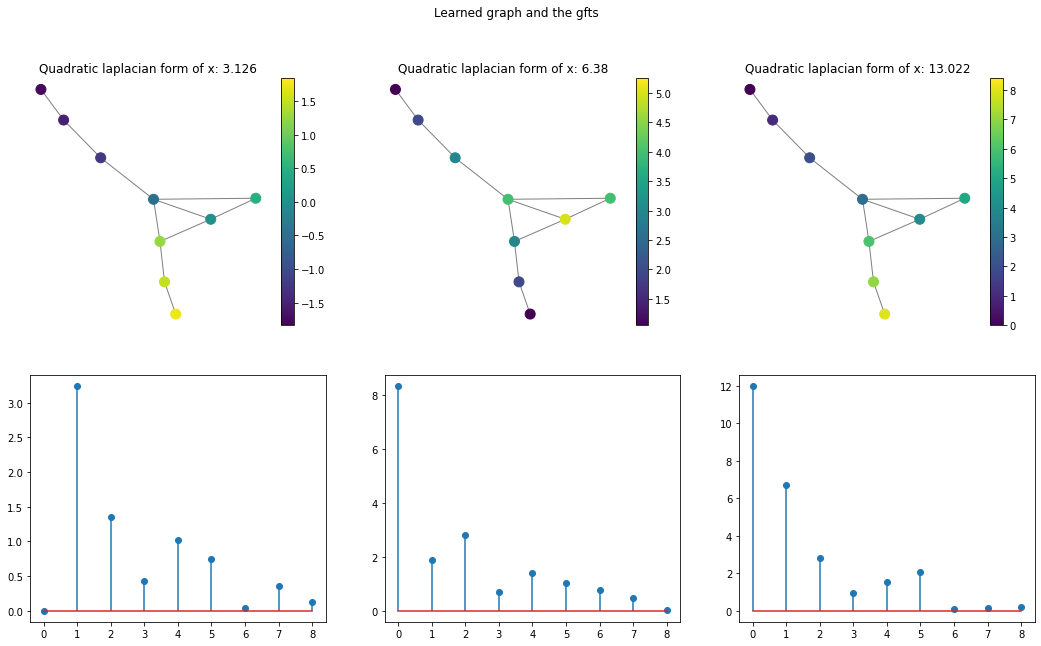

In [31]:
fig, ax = plt.subplots(2, 3, figsize = (18, 10))


for i in [0,1,2]:
    L.plot_signal(x.T[i], ax=ax[0][i])
    ax[1][i].stem(np.abs(L.gft(x.T[i])))
    ax[0][i].axis('off')
#     ax[1][i].axis('off')
    ax[0][i].set_title('Quadratic laplacian form of x: ' + str(np.round(x[:, i] @ (1e6 * L.L) @ x[:, i], 3)))
#     ax[1][i].set_title(y[:, i] @ H.L @ y[:, i])

plt.suptitle('Learned graph and the gfts')
plt.show()

# Fourth example (Kalofolias):